In [5]:
from pathlib import Path
import rioxarray
from tqdm import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as patches

In [6]:
images_dir = Path('../data/raw/1m_resolution')
tif_files = sorted(images_dir.glob("*.tif"))

In [7]:
len(tif_files)

3727

In [8]:
bad_tifs = [
    Path("../data/raw/1m_resolution/USGS_1m_x47y370_CA_SanDiegoQL2_2014.tif"),
    Path("../data/raw/1m_resolution/USGS_1m_x48y370_CA_SanDiegoQL2_2014.tif"),
    Path("../data/raw/1m_resolution/USGS_1m_x49y370_CA_SanDiegoQL2_2014.tif"),
    ]

In [9]:
tif_files = [tif_file for tif_file in tif_files if tif_file not in bad_tifs]

In [10]:
len(tif_files)

3724

In [7]:
images = [rioxarray.open_rasterio(tif_file) for tif_file in tqdm(tif_files)]

  0%|          | 0/3724 [00:00<?, ?it/s]

100%|██████████| 3724/3724 [00:23<00:00, 157.09it/s]


In [12]:
bounds_file = Path("../data/raw/1m_resolution/all_bounds_4269.txt")
lines = bounds_file.read_text().splitlines()
all_bounds = [
    list(map(float, line.strip("()").split(",")))
    for line in lines
]

In [14]:
all_bounds[0]

[-123.1283092021996,
 45.513411504641155,
 -122.99992444380294,
 45.60359758880473]

In [15]:
len(all_bounds)

3724

In [16]:
# Load US Map
map_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/tlgpkg_2024_a_us_nationgeo.gpkg")
map_5070 = map_gdf.to_crs(epsg=5070)

# Load the levees file
levees_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/levees.gpkg")

# US Cities Coordinates
US_Cities = {
   "Los Angeles": (34.0522, -118.2437),
   "Philadelphia": (39.9526, -75.1652),
   "Dallas": (32.7767, -96.7970),
   "Chicago": (41.8781, -87.6298),
   "Houston": (29.7604, -95.3698),
   "Kansas City": (39.0997, -94.5786),
   "Phoenix": (33.4484, -112.0740),
   "San Diego": (32.7157, -117.1611),
   "New York": (40.7128, -74.0060),
   "San Jose": (37.3382, -121.8863),
   "Salt Lake City": (40.7608, -111.8910),
   "Denver": (39.7392, -104.9903),
   "Omaha": (41.2565, -95.9345),
   "Albuquerque": (35.0844, -106.6504),
   "Sacramento": (38.5816, -121.4944),
   "St. Louis": (38.6270, -90.1994),
   "Scranton": (41.4080, -75.6624),
   "Memphis": (35.1495, -90.0490),
   "Seattle": (47.6062, -122.3321),
   "Portland": (45.5051, -122.6750),
   "Orlando": (28.5383, -81.3792),
   "Miami": (25.7617, -80.1918),
   "Fargo": (46.8772, -96.7898),
   "Raleigh(ish)": (35.7796, -78.6382),
   "Indianapolis": (39.7684, -86.1581),
   "Cincinnati": (39.1031, -84.5120)
}

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'tlgpkg_2024_a_us_nationgeo.gpkg': 'State' (default), 'Core_Based_Statistical_Area', 'Combined_Statistical_Area', 'Metropolitan_Division', 'ZIP_Code_Tabulation_Area_5_Digit_20', 'Urban_Area_20'. Specify layer parameter to avoid this warning.
  result = read_func(
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


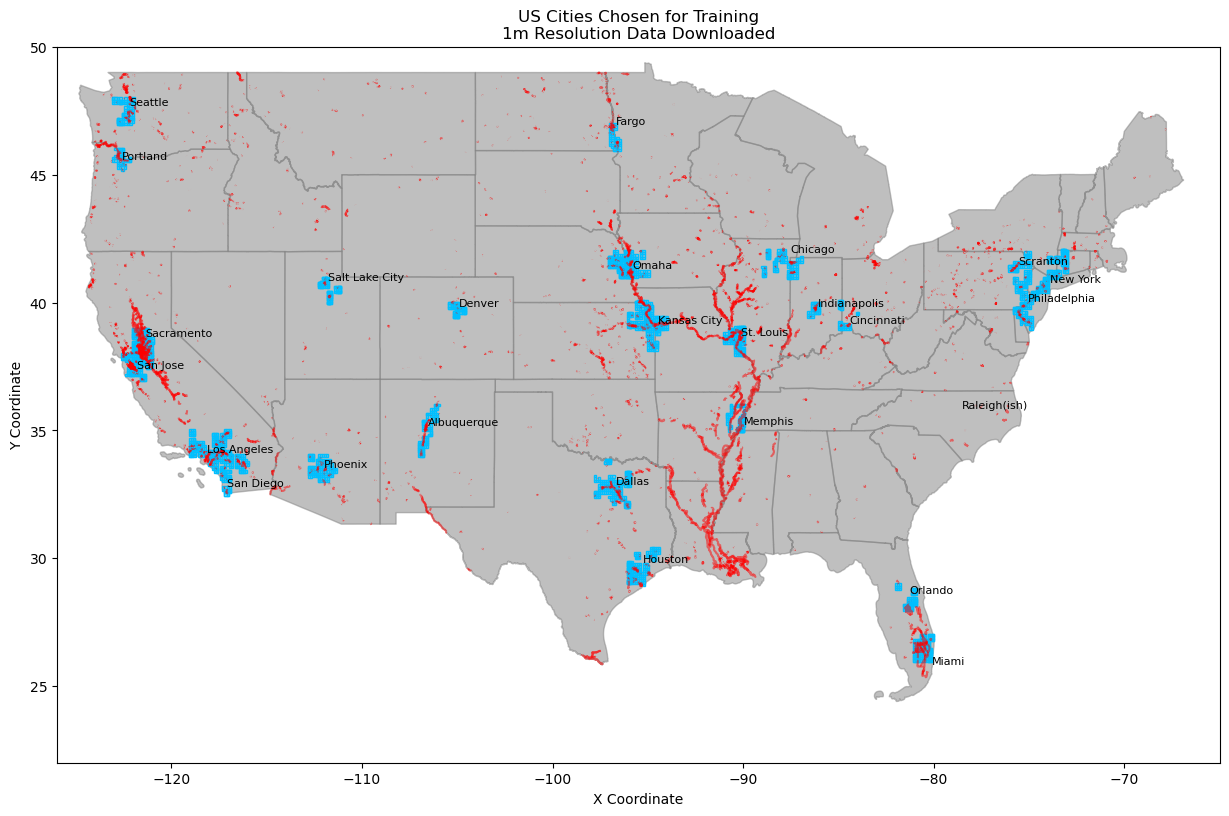

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))

# USA Map
map_gdf.plot(ax=ax, color='grey', alpha=0.5, edgecolor='grey')

# USA Cities
for city, coords in US_Cities.items():
    ax.scatter(*coords, color='darkblue')
    ax.text(coords[1]+0.1, coords[0]+0.1, city, fontsize=8)

# Plot the bounds of each image
for i, bound in enumerate(all_bounds):

    rect = patches.Rectangle((bound[0], bound[1]), bound[2] - bound[0], bound[3] - bound[1], linewidth=1, edgecolor='deepskyblue', facecolor='none', label=f'Image {i+1}' if i == 0 else "")
    ax.add_patch(rect)

levees_gdf.plot(ax=ax, color='red', alpha=0.5)

min_lat, max_lat = 22, 50
min_lon, max_lon = -126, -65

# Set axis limits to only contiguous USA
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

plt.title('US Cities Chosen for Training\n1m Resolution Data Downloaded')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()